### Dataset downloaded from https://www.kaggle.com/bryanb/abstract-art-gallery/
#### The dataset consists of 2782 abstract images

In [1]:
# Import Libraries
import torch
import torchvision
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
import torchvision.datasets
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
transform_abs = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
dataset = torchvision.datasets.ImageFolder(root="/home/Zeeshan/GAN/Abstract_gallery", transform=transform_abs)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

LEARNING_RATE = 0.00004
BATCH_SIZE = 128
IMAGE_SIZE = 128
LATENT_DIM = 100
NUM_EPOCHS = 5
CHANNELS_IMG = 3
FEATURES_GEN = 128
FEATURES_DISC = 128

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)

In [6]:
train_data= DataLoader(dataset, BATCH_SIZE , shuffle=True)

In [7]:
def denorm(img_tensor):
    return img_tensor * 0.5 + 0.5

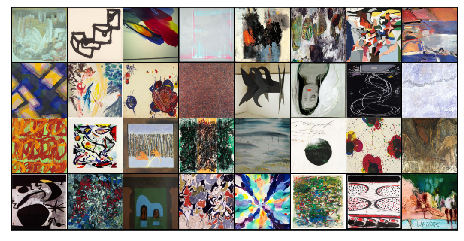

In [8]:
def show_image(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.detach()[:32]), nrow=8).permute(1,2,0))
        break
        
show_image(train_data)

In [9]:
#randomly initialized from a Normal distribution with mean=0, stdev=0.02.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

In [10]:
def get_generator_block(input_dim, output_dim,kernel_size,stride):
    return nn.Sequential(
        nn.ConvTranspose2d(input_dim, output_dim,kernel_size,stride),
        nn.BatchNorm2d(output_dim),
        nn.LeakyReLU(0.02,True),
    )

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=100 ,channels_img=CHANNELS_IMG, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim*8,4,1),               #5x5    x hidden_dim * 8
            get_generator_block(hidden_dim*8, hidden_dim * 4,3,2),      #11x11   x hidden_dim * 4
            get_generator_block(hidden_dim * 4, hidden_dim * 2,4,2),    #23x23   x hidden_dim * 2
            get_generator_block(hidden_dim * 2, hidden_dim,4,2 ),       #49x49   x hidden_dim 
            nn.ConvTranspose2d(hidden_dim,channels_img ,5,3),           #128  x 128  x CHANNELS_IMG
            nn.Tanh()
        )
    def forward(self, _input ):
        return self.gen(_input)
    
    def get_gen(self):
        return self.gen

In [12]:
def get_discriminator_block(in_channel, out_channel, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel,kernel_size,stride),
        nn.LeakyReLU(0.02,inplace=True)
    )

In [13]:
class Discriminator(nn.Module):
    def __init__(self, CHANNELS_IMG , hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(CHANNELS_IMG , hidden_dim ,4,2),      #63 x 63 x hidden_dim 
            get_discriminator_block(hidden_dim ,hidden_dim*2 ,3,2),        #31x31 x hidden_dim * 2
            get_discriminator_block(hidden_dim * 2, hidden_dim*4 ,3,2),       #15x15 x hidden_dim * 4
            get_discriminator_block(hidden_dim * 4, hidden_dim*8 ,3,2),         #7x7  x hidden_dim *8
            nn.Conv2d(hidden_dim*8, 1,7,1),                                     #1  x 1  x 1 
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [14]:
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [15]:
gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

In [16]:
gen.apply(weights_init)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.0

In [17]:
disc.apply(weights_init)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (4): Conv2d(1024, 1, kernel_size=(7, 7), stride=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Sigmoid()
  )
)

In [18]:
fixed_noise = torch.randn(128, LATENT_DIM, 1, 1).to(device)

In [19]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.8, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.8, 0.999))
criterion = nn.BCELoss()

In [20]:
gen.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.0

In [21]:
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.02, inplace=True)
    )
    (4): Conv2d(1024, 1, kernel_size=(7, 7), stride=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Sigmoid()
  )
)

In [22]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_losses_real = []
D_losses_fake = []
iters = 0

In [23]:
step=0

In [24]:
print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake = gen(noise)
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        D_losses_real.append(loss_disc_real.item())
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        D_losses_fake.append(loss_disc_fake.item())
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        D_losses.append(loss_disc.item())
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        G_losses.append(loss_gen.item())
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 20 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            step += 1

Starting Training Loop...
Epoch [0/5] Batch 0/22                   Loss D: 49.2188, loss G: 99.2188
Epoch [0/5] Batch 20/22                   Loss D: 44.9219, loss G: 72.8400
Epoch [1/5] Batch 0/22                   Loss D: 40.6953, loss G: 54.6671
Epoch [1/5] Batch 20/22                   Loss D: 31.6745, loss G: 47.0830
Epoch [2/5] Batch 0/22                   Loss D: 28.7864, loss G: 50.6119
Epoch [2/5] Batch 20/22                   Loss D: 8.9844, loss G: 99.2188
Epoch [3/5] Batch 0/22                   Loss D: 9.1224, loss G: 98.4375
Epoch [3/5] Batch 20/22                   Loss D: 6.6406, loss G: 100.0000
Epoch [4/5] Batch 0/22                   Loss D: 6.6406, loss G: 100.0000
Epoch [4/5] Batch 20/22                   Loss D: 2.7344, loss G: 97.6562


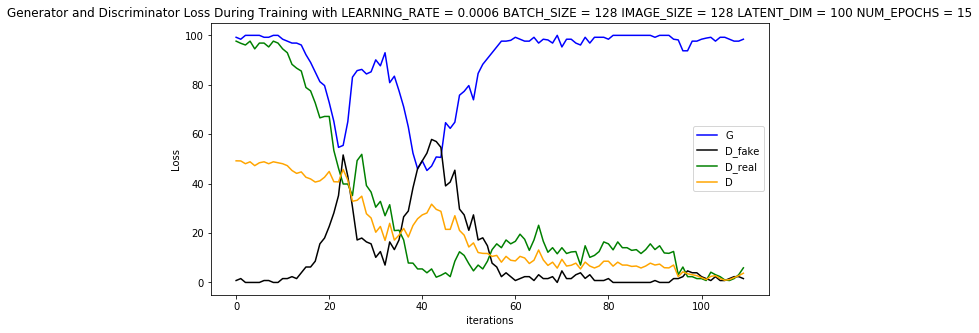

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training with LEARNING_RATE = 0.0006 BATCH_SIZE = 128 IMAGE_SIZE = 128 LATENT_DIM = 100 NUM_EPOCHS = 15")
plt.plot(G_losses,label="G",color='blue')
plt.plot(D_losses_fake,label="D_fake",color='black')
plt.plot(D_losses_real,label="D_real",color='green')
plt.plot(D_losses,label="D",color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

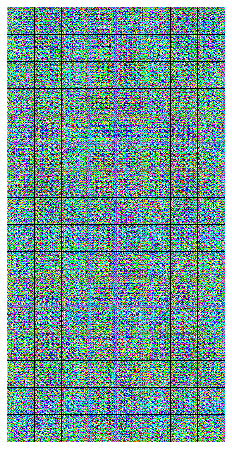

In [26]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

torch.Size([128, 3, 128, 128])
torch.Size([128, 100, 1, 1])


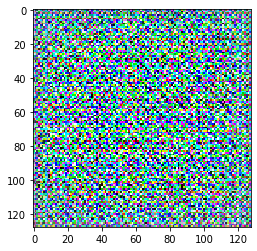

In [27]:
fake=gen(fixed_noise)

print(fake.shape)

print(fixed_noise.shape)

plt.imshow(denorm(fake[0].permute(1,2,0).detach().numpy()))

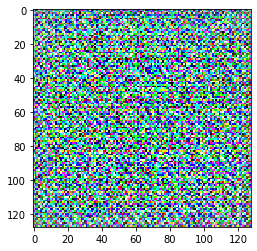

In [28]:
plt.imshow(denorm(fake[-1].permute(1,2,0).detach().numpy()))